# README

This takes the data generated from gen_2DWindow_data.py and converts it into graphs. This experiment is taking 12 curves where there are windows around the null points. These windows around the null points are varied to show how close we need to be to the null point to have improved MSE beyond the conventional method. This code is changed from the npWindow experiment in that both windows vary in the central location. We also allow the SNR to vary.

# Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
# import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator

# Initialization

### Window Analysis

In [2]:


cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

exp_file = 'Frequency_DATA'
exp_date = '21Feb24'

add_tag = "standard"

/home/hamptong2/


In [3]:
with open(f'{cwd_full}{base_file}/Analytical_BIC/{exp_file}/hprParameter_{add_tag}_SNRsuite_{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    SNR_array = dict["SNR_array"]
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    var_reps = dict["var_reps"]
    TI_STANDARD = dict['TI_range']
    handle.close()

T11, T12, c1, c2, T21, T22 = true_params

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

# Functions

In [4]:
def to_readable(file):
    df = pd.read_pickle(file)
    ALL_SNR = np.stack(df["SNR"].values) #shape: (len(center_diff_range))
    ALL_TI = np.stack(df["TI"].values) #shape: (len(center_diff_range))
    ALL_FREQ = np.stack(df["frequency"].values) #shape: (len(center_diff_range), len(TI))

    return ALL_SNR, ALL_TI, ALL_FREQ


In [9]:
def prepare_data():

    freq_ordered = np.zeros((len(TI_STANDARD), len(SNR_array))) # ordering = ["ESPRESSO", "Conventional", "Curve Fit"]

    data_name = f"{cwd_full}{base_file}/Analytical_BIC/{exp_file}/BICfreq_{add_tag}_SNRsuite_{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    SNR, TI, FREQ = to_readable(data_name)

    for index in range(len(TI)):

        temp_SNR = SNR[index]
        temp_TI = TI[index]


        SNR_index = np.where(temp_SNR==SNR_array)[0]
        TI_index = np.where(temp_TI==TI_STANDARD)[0]

        freq_ordered[TI_index, SNR_index] = FREQ[index]

    return freq_ordered

# Data Organization

In [10]:
freq_mat = prepare_data()

Retrieving data for /home/hamptong2/Stabilization/Analytical_BIC/Frequency_DATA/BICfreq_standard_SNRsuite_21Feb24.pkl


# Plotting

In [14]:
TI_SR = np.append(0,np.logspace(1,np.log10(3*T12),11))//1

temp = set(TI_SR)
indices_SR = [i for i, val in enumerate(TI_STANDARD) if val in temp]
freq_SR = freq_mat[indices_SR,:]
assert(freq_SR.shape[0] == len(TI_SR))

In [15]:
np1_array = TI1star*(1+np.array([-.15, -.125, -0.1, -0.075, -0.05, -0.025, 0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15]))//1
np2_array = TI2star*(1+np.array([-.15, -.125, -0.1, -0.075, -0.05, -0.025, 0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15]))//1

temp = set(np1_array)
indices_np1 = [i for i, val in enumerate(TI_STANDARD) if val in temp]
freq_np1 = freq_mat[indices_np1,:]
assert(freq_np1.shape[0] == len(np1_array))

temp = set(np2_array)
indices_np2 = [i for i, val in enumerate(TI_STANDARD) if val in temp]
freq_np2 = freq_mat[indices_np2,:]
assert(freq_np2.shape[0] == len(np2_array))

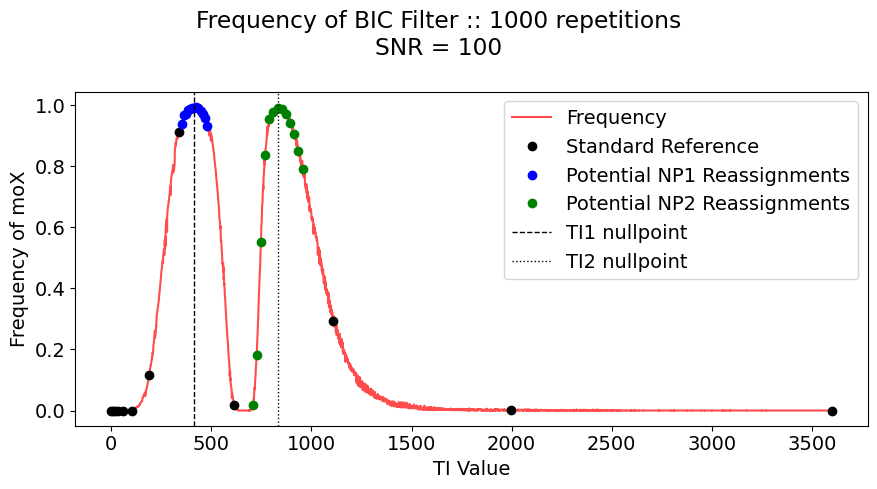

In [21]:
SNR_oi = 0
assert(SNR_oi < len(SNR_array))

plt.rc('font', size = 14)
fig, ax = plt.subplots(1,1, figsize=(9,5), tight_layout=True)
fig.suptitle(f'Frequency of BIC Filter :: {var_reps} repetitions\nSNR = {SNR_array[SNR_oi]}')


ax.plot(TI_STANDARD, freq_mat[:,SNR_oi], alpha = 0.7, color = 'r', label = 'Frequency')

ax.plot(TI_SR, freq_SR, marker = 'o', color = 'k', ls = '', label = "Standard Reference")
ax.plot(np1_array, freq_np1, marker = 'o', color = 'b', ls = '', label = "Potential NP1 Reassignments")
ax.plot(np2_array, freq_np2, marker = 'o', color = 'g', ls = '', label = "Potential NP2 Reassignments")

ax.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = ':')

ax.set_xlabel('TI Value')
ax.set_ylabel('Frequency of moX')
# ax.set_title('TI1 nullpoint')
ax.legend()

plt.show()